In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [4]:
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## Accuracy and Dummy Model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

np.int64(1132)

In [11]:
(y_val == churn_decision).sum() / len(y_val)

np.float64(0.8034066713981547)

In [12]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

From our total 1.409 custormers from the validation dataset, we got correct 1.132 predictions. Our accuracy is the ratio between these two, which gives us approximately 80%

To make our decision, we used a threshold of 0.5. Is this a good threshold?

In [13]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


0,5 is actually the best threshold, with a small advantage to 0,55

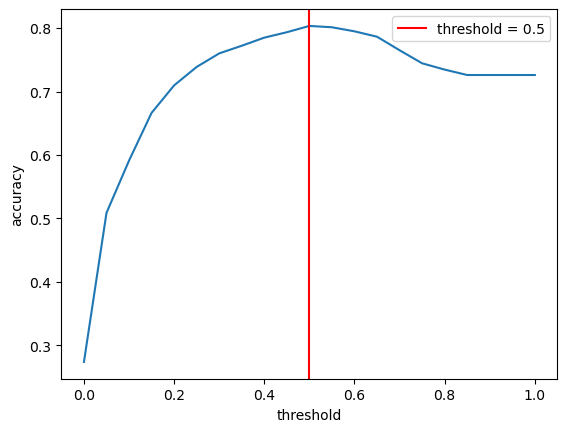

In [16]:
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.axvline(x = 0.5, color = 'red', label = 'threshold = 0.5')
plt.legend()
plt.show()

For threshold = 1, we say customers are churning if the score is above 1.0, which technically means that every customer was treated as non-churning because there are no values or almost no values that are higher than 1. We can check using 'y_pred >= 1.0' 

In [17]:
from  collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

The Counter counted only False values. Which means that threshold = 1 and therefore y_pred >= 1 predicts every customer are non-churning. There no intervention required by the company to engange these customers.

The accuracy for this dummy model that predicts all customer as non-churning is actually pretty decent with 72.6% accuracy.Why do we need to bother with our 80% model if all we get is a 7% gain from our dummy model?

**That's the main issue with accuracy.**

Accuracy doesn't tell us how good a model is for this particular case. Let's look at the distribution of our y_val.

In [19]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [20]:
y_val.mean()

np.float64(0.2739531582682754)

There are a lot more non-churning customers than churning ones.So actually, if we look at the mean of this variable, we see that 27 percent of the users are churning and 72.6 percent are non-churning. So this is actually exactly the same value we are getting in the accuracy of our dummy model.

So, if we predict everyone as non-churning for some of them, the model gets it correctly, but for some of them, this is incorrect. And it's incorrect only for the cases when the customers are churning. So for these people, who are actually churning the model will of course be incorrect and for the rest it will be correct. So it will be correct in 73 percent of cases exactly for those who are non-churning, and it will make a mistake in 27 percent of cases which are exactly all the people who are churning.

So here in our case since there are 70 percent of people who are non-churning, we have **class imbalance!**

It means we have a lot more customers who are non-churning than churning ones. So the imbalance is actually 3 to one here. 

That's why in cases like that, when we have class imbalance, these dummy models like that one, if we just say let's predict the majority class, let's predict all the people who are non-churning, these models will already have good accuracy. So that's why accuracy as a score for cases with class imbalance can be quite misleading.






## Confusion Matrix

- Different types of errors and correct decisions
- Arranging them in a table

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
actual_negative

array([ True,  True,  True, ...,  True, False, False], shape=(1409,))

In [23]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [24]:
predict_positive

array([False, False, False, ..., False,  True,  True], shape=(1409,))

In [25]:
(predict_positive & actual_positive).sum()

np.int64(210)

In [26]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [27]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [29]:
accuracy = (tn + tp) / confusion_matrix.sum()
accuracy

np.float64(0.8034066713981547)

## Precision and Recall

**Precision -** Fraction of positive decision that turned out to be correct.

We want to look out for the customers we predicted as churn, and get the TP and FP. The precision will be the TP divided by the total number of positive predictions

In [30]:
p = tp / (tp + fp)
p

np.float64(0.6752411575562701)

In [31]:
tp

np.int64(210)

In [32]:
tp + fp

np.int64(311)

Precision is 67,5%. It means we will send a promotion email to 311 customers and only 210 are actually going to churn. Which means approximately 33% of them are going to be mistakes, customers who are not suppose to get the email but get it anyway.

**Recall -** Fraction of positive examples we identified correctly. Out of the customers identified as positives, given our decision threshold, recall will measure the ones we identified correctly as churning.

We want to look at customers who are actually going to churn. We are interested in the customers who are labeled as y = 1, those will be the TP and FN.

In [33]:
r = tp / (tp + fn)
r

np.float64(0.5440414507772021)

In [34]:
tp + fn

np.int64(386)

Recall is 54,4%. It means that for 46% of customers who are churning, we failed to identify them.


If we gather the three metrics:
- Accuracy = 80%
- Precision = 68%
- Recall = 54%

Our model, who started with a high level accuracy doesn't seem so good anymore. We failed to identified 46% of users and we actually send promotion emails to 33% of users who are not going to churn but will probably take advantage of our discount.

So accuracy can be misleading, specially when we have cases of class imbalance.

## ROC Curves

#### TPR and FRP

- False Positive Rate = FP / (FP + TN) --> Fraction of false positive among all negative examples (y=0)
    - We want the value of False Positives to be as small as possible (minimize)

- True Positive Rate = TP / (TP + FN) --> Fraction of true positive among all positive examples (y=1)
    - We want the value of True Positives to be as big as possible (maximize)

In [35]:
tpr = tp / (tp + fn)
tpr # same as recall

np.float64(0.5440414507772021)

In [36]:
fpr = fp / (fp + tn)
fpr 

np.float64(0.09872922776148582)

In [37]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [38]:
scores

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(912), np.int64(1), np.int64(111)),
 (np.float64(0.02), np.int64(384), np.int64(830), np.int64(2), np.int64(193)),
 (np.float64(0.03), np.int64(383), np.int64(766), np.int64(3), np.int64(257)),
 (np.float64(0.04), np.int64(381), np.int64(715), np.int64(5), np.int64(308)),
 (np.float64(0.05), np.int64(379), np.int64(685), np.int64(7), np.int64(338)),
 (np.float64(0.06), np.int64(377), np.int64(659), np.int64(9), np.int64(364)),
 (np.float64(0.07), np.int64(372), np.int64(641), np.int64(14), np.int64(382)),
 (np.float64(0.08), np.int64(371), np.int64(612), np.int64(15), np.int64(411)),
 (np.float64(0.09), np.int64(369), np.int64(580), np.int64(17), np.int64(443)),
 (np.float64(0.1), np.int64(366), np.int64(556), np.int64(20), np.int64(467)),
 (np.float64(0.11), np.int64(365), np.int64(528), np.int64(21), np.int64(495)),
 (np.float64(0.12), np.int64(365), np.int64(509), 

In [39]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [40]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,75,20,311,1003,0.194301,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


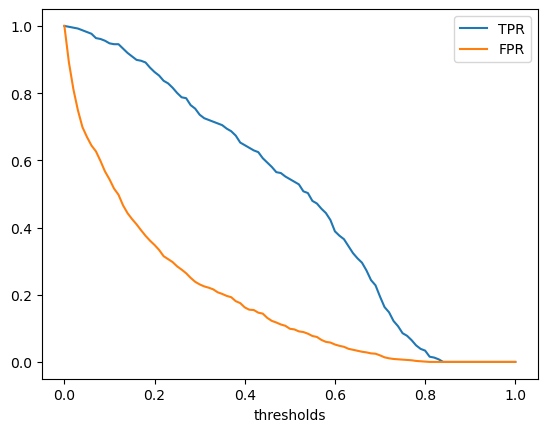

In [41]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.xlabel('thresholds')
plt.legend()
plt.show()

For threshold of 0, both TPR and FPR are 1, for these dummy model that predicts everyone as churning, for them TRP is 100% because for all churning customers all are identified correctly and FPR is 100%, so for all non-churning ones we predict all of them incorrectly as churning.

From there onwards both rate go down, and the goal is for FPR to go down as fast as possible, we want to minimize it. The opposite for TRP, we want it to maximize it.

#### Random Model

In [42]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [43]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [44]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [45]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [46]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


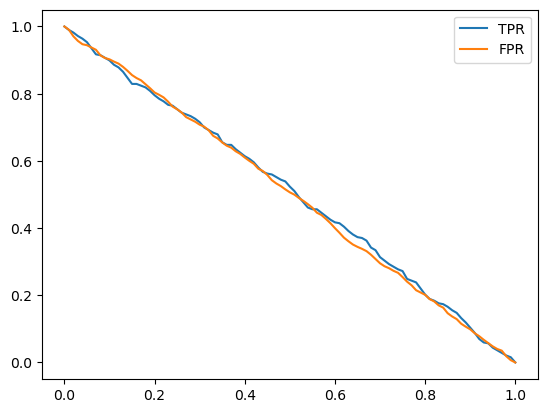

In [47]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()
plt.show()

#### Ideal Model

The ideal model orders customers in such a way that first we have all the customers who are non-churning so all these people after ordering they are non-churning and people after that, all of them are churning.. And let's say if for us the threshold is 72, so 72 percent of non-churning and 28% of churning after ordering the customer, then our model will have 100% accuracy.

In [48]:
num_neg = (y_val == 0).sum() #count the number of negative examples on our dataset
num_pos = (y_val == 1).sum() #count the number of positive examples on our dataset
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [49]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) # We want to create an array that contains first negative examples and then positive ones. It should have 1.023 zeros and 386 ones.

y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [50]:
# We need do create our predictions with numbers between 0 and 1 with the size of the number of observations in our val dataset
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [51]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [52]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

It predicts everything correctly for customers below and above the 0.726 threhold.

In [53]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


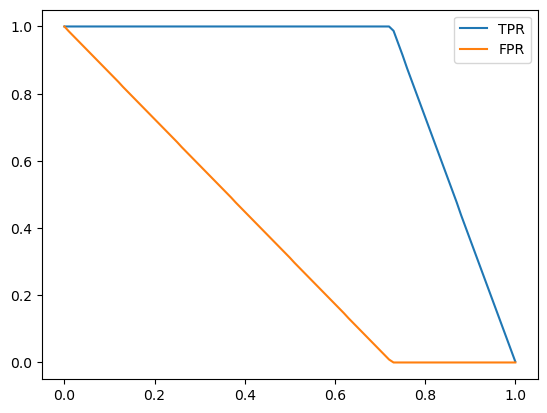

In [54]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()
plt.show()

The TPR always stays close to 1 and starts to go down around the 0.726 threshold. Until that mark, this model can identify churning customer correclty (blue horizontal line).  

As for people who are not churning, when it says they are churning it's not always true, it only becomes trye when it crosses the 0.726 threshold (orange horizontal line). For example, for a threshold of 0.4, the FPR is +/- 45%, so it means that it still makes mistakes simply because we cut at 0.4 so for approximately 20 percent of people who are predicted as non-churning but they're simply below the this threshold of 0.726 we predict them as churning even though they are not. So we are making a mistake at the 0.4 threshold that is why the FPR is 45% but it goes down and at the threshold of this threshold it classifies everything correctly.

**This model doesn't exist in reality but helps us benchmark our model against this one.**

Putting all together

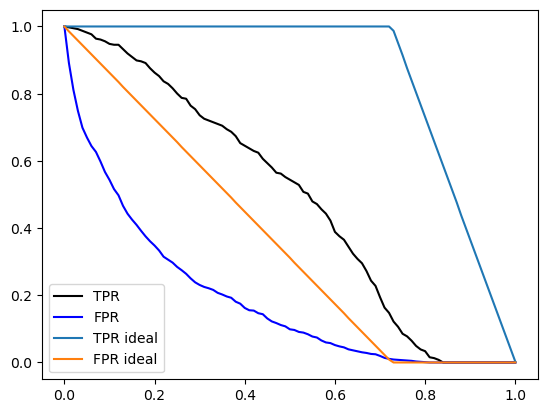

In [55]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()
plt.show()

Our true positive rate we actually want to be as close as possible to TPR ideal so we see that it's quite far apart so even at the threshold 0.5. Right so when this model has a true positive rate of 100 percent so we are making quite a lot of mistakes and likewise this false positive rate it's quite far from the FPR ideal. 

Plotting it against the threshold is not always intuitive because for example for this model that we have, the best threshold as we know is 0.5 at least in terms of accuracy but for this model the best threshold is 0.726 right so there they have different thresholds what we can do however is to plot false positive rate against true positive rate so in a slightly different manner so here we don't plot the thresholds we just look at only through positive rate and false positive rate.

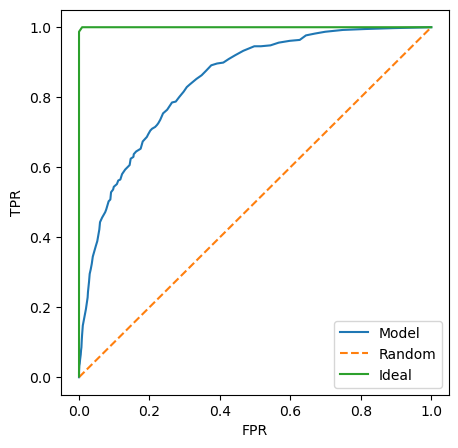

In [56]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

In the top left corner of the ideal model, when TPR = 100% and FPR = 0%, it's the north star. We also know that for that point, the threshold is 0.726.

We want our ROC Curve to be as close as possible to this ideal spot and as far as possible from the random baseline.

- Interpretation:
When both TRP = FPR = 0% (left bottom corner), this happens at a bigger threshold, let's say of 1, where every customer we predict as non-churning so our true positive rate is zero because basically we don't predict anyone as churning. That's why it's always zero and the false positive rate is zero as well because uh there are no false positives we only have true negatives there.

So this is where we start so we start at the threshold of 1 here and we finish in the top right corner with threshold of 0.

So this is where our model has TPR = 100% because we predicted everyone as churning, we are able to identify all churning users, but we also make a lot of mistakes and have a lot of false positives. We are incorrelty identifying non-churning ones, that is why the FPR is also 100%.

In [57]:
from sklearn.metrics import roc_curve

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

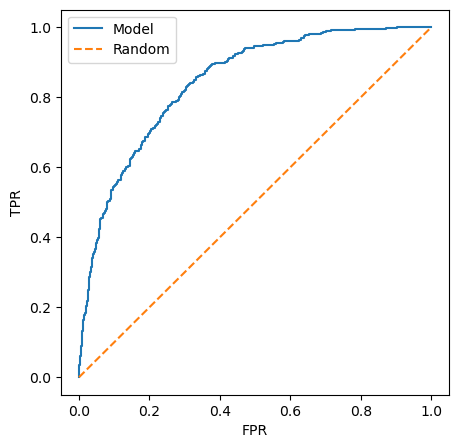

In [59]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

## ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

In [60]:
from sklearn.metrics import auc

In [61]:
auc(fpr, tpr) #values from scikit-learn

0.8438454408703449

In [62]:
auc(df_scores.fpr, df_scores.tpr) #values from our own iterations

0.8438112530958929

In [63]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
roc_auc_score(y_val, y_pred)

0.8438454408703449

AUC tells us what's the probability that a randomly selected positive example has a score that is higher than a randomly selected negative example.

We can code this:

In [66]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [67]:
import random

In [68]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1) #randomly selected positive example
    neg_ind = random.randint(0, len(neg) - 1) #randomly selected negative example

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n # we wanto to check how many times our condition pos[pos_ind] > neg[neg_ind] is true, out of our 100.000 tries

0.84197

In [69]:
# We can do the same comparison with numpy and do the same in a vectorized way

n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84648)

## Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

We split our data in train - val - test, and forget about test. Train and Validation become one full train dataset.

We split the full train into k number of folds, and train the model in a train dataset made up of k-1 folds, get the function g(xi), we evaluate the function into the remaining fold that will serve as validation and then we compute the AUC in this validation fold.

We repeat the process using different combinations of folds in the train and validation datasets. We gather the scores for AUC and compute the mean and standard deviation of those scores. The standard deviation will show us how stable the model is, how much the scores differ across the different folds.

In [ ]:
# Function for training
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records') # convert the dataframe into a list of dictionaries
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    return dv, model

In [71]:
dv, model = train(df_train, y_train)

c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
# Function for making predictions
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records') # convert the dataframe into a list of dictionaries

    X = dv.transform(dicts) # creates a feature matrix using the vectorizer 
    y_pred = model.predict_proba(X)[:, 1] # user the model predict_proba and gets the predictions from the second column

    return y_pred


In [73]:
y_pred = predict(df_val, dv, model)

Now that we have the functions, let's implement the KFold using sklearn

In [75]:
from sklearn.model_selection import KFold

In [76]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In the kfold object there's the split method. It gets our feature matrix ou just a dataframe and returns two arrays to be used as train indexes and validation indexes.

In [79]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [81]:
len(train_idx), len(val_idx)

(5070, 564)

In [82]:
len(df_full_train)

5634

Since we defined n_splits = 10, we see that our split methods uses 10% for validation and 90% for train. We can use iloc to select our train and validation dataframes.

In the end, we don't end up using the next method, we iterate of the different splits obtained from the split method

In [ ]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules

0.841 +- 0.012


c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Each iteration takes some time. We can use a library tqdm to see the progression of each iteration

In [88]:
from tqdm.auto import tqdm

In [89]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules

In [90]:
scores

[0.8478921171063721,
 0.8410426980198019,
 0.8557048652060528,
 0.8344745288453626,
 0.8268455334987593,
 0.8372294372294372,
 0.8443015304461088,
 0.8186195445920303,
 0.8456054542759746,
 0.862626466337266]

We have the scores evaluated in the different folds. Let's compute the mean and standard deviation

In [91]:
np.mean(scores), np.std(scores)

(np.float64(0.8414342175557167), np.float64(0.012327601937973576))

In [93]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.841 +- 0.012


The average score along the folds is 84% with a standard deviation of approximately 1%

Our Logistic Regression model has a parameter C, and we can tune that parameter. C would be the equivalent to the regularization parameter discuss in Regression.

The default value for C is 1. We can add this parameter C into our train function

In [105]:
# Function for training
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records') # convert the dataframe into a list of dictionaries
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C = C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [102]:
dv, model = train(df_train, y_train, C=10) # This is how we can control out to train for different values of parameter C.

We can iterate for different values of C

In [104]:
## adding this to remove warnings, for reading purposes
import warnings
from sklearn.exceptions import ConvergenceWarning

In [106]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    with warnings.catch_warnings(): # Filter warnings for reading purposes
        warnings.filterwarnings("ignore", category=ConvergenceWarning) # Filter for the specific warning from sklearn
    
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

        scores = []

        for train_idx, val_idx in kfold.split(df_full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train.churn.values
            y_val = df_val.churn.values

            dv, model = train(df_train, y_train, C=C)
            y_pred = predict(df_val, dv, model)

            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


We see that with small C=0.001 the AUC drops a litte bit.

C=1 seems the best one, which ends up being the default value as well. 

All have the same mean performance and same standard deviation, we can just go with C=1 to train our final model using the full_train dataset and evaluate in our test dataset.

In [108]:
scores

[0.8446122567528318,
 0.8452212455303934,
 0.8334015653220952,
 0.8348568299545949,
 0.8517304132283267]

In [107]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

c:\Users\filip\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.858525084771469

AUC was 85.9% a bit better than the mean performance on the validation folds. We can see in the scores list that there was actually a fold with a AUC similar of 85.17%

**When to use Cross Validation?**

When should I use cross validation and when I use should validation hold out dataset. 

Most of the time usual holdout data set is fine so especially in cases when your data set is quite large you can just hold out a part of the data set for validation.

If your data set is smaller or you also want to have standard deviation to understand how stable your model is and how much it varies across different folds then you can use cross validation. And for bigger data set maybe number of splits could be two or three, for smaller data set maybe you want to do more splits like maybe 10 or something like this.